# Lagged Correlation Analysis of PI Control

In [1]:
import os
import warnings
warnings.filterwarnings("ignore", message="invalid value encountered in true_divide")
warnings.filterwarnings("ignore",message="Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range")
warnings.filterwarnings("ignore", message="invalid value encountered in reduce")

import xarray as xr
import numpy as np
import scipy.stats as stats
import pickle as pkl

import matplotlib.pyplot as plt
import matplotlib as mpl

import cmocean.cm as cm

In [14]:
mpl.rcParams['figure.dpi']= 120

In [3]:
def open_metric(var, reg, metric, timescale='monthly', ens_type=''):
    
    writedir = '/home/bbuchovecky/storage/so_predict_derived/'
    
    if metric == 'anom' or metric == 'mean':
        subdir = 'CTRL/'+var.upper()+'/'
        filename = var.lower()+'_ts_'+reg+'_'+timescale+'_'+metric+'.nc'
    
    if metric == 'ppp':
        subdir = 'PPP/'+var.upper()+'/'
        if ens_type != '':
            ens_type += '_'
        filename = var.lower()+'_ts_'+reg+'_'+timescale+'_'+ens_type+'ppp.nc'
        
    return xr.open_dataset(writedir+subdir+filename)

def get_plotting_labels():
    file = open('/home/bbuchovecky/storage/so_predict_derived/plotting_dicts.pkl','rb')
    plotting_dicts = pkl.load(file)
    file.close()
    
    reg_names = plotting_dicts['reg_names']
    var_su_names = plotting_dicts['var_su_names']
    abbrv_month_names = plotting_dicts['abbrv_month_names']
    
    return reg_names, var_su_names, abbrv_month_names

# Autocorrelation

## Test case
The goal here is to compute the lagged correlations for all initial months with lags of -4 to +4 months for a single variable.

### Single init month

In [101]:
years = 10
N = 12 * years

## generate random time series of length N
## 0 is Jan, 1 is Feb, ..., 11 is Dec
a = np.arange(N)
print('a', a, '\n')

## initialization month
init = 0

## max absolute value lag (in months)
lag = 2

for (im,m) in enumerate(range(-lag,lag+1)):    
#     trim = 12*(abs(m)//12+1)
    trim = 12*((abs(m)-1)//12+1)
        
    if m < 0:
        tmp_a_init = a[init+trim:N:12]
        tmp_a_lag = a[init+trim+m:N-trim+init:12]

    else:
        tmp_a_init = a[init:N-m:12]
        tmp_a_lag = a[init+m:N:12]
     
    if tmp_a_init.size != tmp_a_lag.size:
        print('### lag', m)
        print('### trim', trim)
        print('### tmp_a_init ', tmp_a_init.size)
        print('### tmp_a_lag ', tmp_a_lag.size)
        print('tmp_a_init', tmp_a_init)
        print('tmp_a_lag ', tmp_a_lag, '\n')
        
    else:
        print('lag', m)
        print('trim', trim)
        print('tmp_a_init', tmp_a_init)
        print('tmp_a_lag ', tmp_a_lag, '\n')

a [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119] 

lag -2
trim 12
tmp_a_init [ 12  24  36  48  60  72  84  96 108]
tmp_a_lag  [ 10  22  34  46  58  70  82  94 106] 

lag -1
trim 12
tmp_a_init [ 12  24  36  48  60  72  84  96 108]
tmp_a_lag  [ 11  23  35  47  59  71  83  95 107] 

lag 0
trim 0
tmp_a_init [  0  12  24  36  48  60  72  84  96 108]
tmp_a_lag  [  0  12  24  36  48  60  72  84  96 108] 

lag 1
trim 12
tmp_a_init [  0  12  24  36  48  60  72  84  96 108]
tmp_a_lag  [  1  13  25  37  49  61  73  85  97 109] 

lag 2
trim 12
tmp_a_init [  0  12  

### All (12) init months

In [12]:
maxlag = 2

## generate random time series of length N
years = 10
N = 12 * years
a = np.random.randint(0,100, (N))

## rows are different init months, cols are different lags
r_matrix = np.zeros((12, 2*maxlag+1))
p_matrix = np.zeros((12, 2*maxlag+1))

lag_matrix = np.zeros((12, 2*maxlag+1))
init_matrix = np.zeros((12, 2*maxlag+1))

for (it,init) in enumerate(range(0,12)):
    for (ig,lag) in enumerate(range(-maxlag,maxlag+1)):    
        trim = 12*((abs(lag)-1)//12+1)
        init_matrix[it][ig] = init
        lag_matrix[it][ig] = lag

        if lag < 0:
            tmp_a_init = a[init+trim:N:12]
            tmp_a_lagged = a[init+trim+lag:N-trim+init:12]

        else:
            tmp_a_init = a[init:N-lag:12]
            tmp_a_lagged = a[init+lag:N:12]

        r_matrix[it][ig], p_matrix[it][ig] = stats.pearsonr(tmp_a_init, tmp_a_lagged)

## Create function

In [17]:
def compute_lagged_autocorr(a, maxlag):
    ## convert DataArray to NumPy array
    a = a.values
    N = a.size
    
    ## rows are different lags, cols are different init months
    r_matrix = np.zeros((2*maxlag+1, 12))
    p_matrix = np.zeros((2*maxlag+1, 12))

    init_matrix = np.zeros((2*maxlag+1, 12))
    lag_matrix = np.zeros((2*maxlag+1, 12))
    
    for (it,init) in enumerate(range(0,12)):
        for (ig,lag) in enumerate(range(-maxlag,maxlag+1)):    
            trim = 12*((abs(lag)-1)//12+1)
            init_matrix[ig][it] = init
            lag_matrix[ig][it] = lag

            if lag < 0:
                tmp_a_init = a[init+trim:N:12]
                tmp_a_lagged = a[init+trim+lag:N-trim+init:12]

            else:
                tmp_a_init = a[init:N-lag:12]
                tmp_a_lagged = a[init+lag:N:12]

            r_matrix[ig][it], p_matrix[ig][it] = stats.pearsonr(tmp_a_init, tmp_a_lagged)
            
    return r_matrix, p_matrix, init_matrix, lag_matrix

## Create figures

In [45]:
## compute t-test with 95 degrees of freedom (95% confidence interval) to determine threshold for hatching
def plot_single_lagged_autocorr(variable, region, maxlag=24, threshold=0.75, hatch='//', figsize=(6,7)):
    
    ts = open_metric(variable, 'so', 'anom')[region]
    
    r, p, inits, lags = compute_lagged_autocorr(ts, maxlag=maxlag)

    reg_names, var_su_names, abbrv_month_names = get_plotting_labels()

    fig,ax = plt.subplots(figsize=figsize)
    im = ax.pcolormesh(r, vmin=-1.0, vmax=1.0, cmap=cm.balance, edgecolor='k', linewidth=0.01)

    # for (i, j), z in np.ndenumerate(inits):
    #     ax.text(j+0.5, i+0.5, '%3d'%z, ha='center', va='center', fontsize=4)

    ax.set_yticks((np.arange(r.shape[0]) + 0.5)[::4])
    ax.set_yticklabels(np.arange(-maxlag,maxlag+1)[::4])
    ax.set_ylabel('LAG')

    ax.set_xticks(np.arange(r.shape[1]) + 0.5)
    ax.set_xticklabels(abbrv_month_names)
    ax.set_xlabel('INIT MONTH')
    
    ax.set_title(reg_names[region]+' '+var_su_names[variable]+' autocorrelation')
   
    cb = fig.colorbar(im, ax=ax, label='Correlation coefficient')

    if hatch:
        masked = np.ma.masked_array(r, mask=np.where(abs(r) > threshold, 0, 1))
        masked_im = ax.pcolor(masked, hatch=hatch, alpha=0)

        cb.ax.plot([-1,1], [threshold,threshold], color='k')
        cb.ax.plot([-1,1], [-threshold,-threshold], color='k')
        cb.ax.fill_between([-1,1], [1,1], [threshold,threshold], hatch=hatch, alpha=0)
        cb.ax.fill_between([-1,1], [-threshold,-threshold], [-1,-1], hatch=hatch, alpha=0)

In [16]:
var = 'sie'
plot_lagged_autocorr(var, 'SouthernOcean', hatch=False)

In [18]:
def plot_regional_lagged_autocorr(variable, maxlag=24, threshold=0.75, hatch='//', figsize=(14,12)):
    reg_names, var_su_names, abbrv_month_names = get_plotting_labels()
    region_list = ['Weddell', 'Indian', 'WestPacific', 'SouthernOcean', 'Ross', 'AmundBell']
    
    fig,ax = plt.subplots(2, 3, figsize=figsize)
    
    for (ireg,reg) in enumerate(region_list):  
        ts = open_metric(variable, 'so', 'anom')[reg]
        r, p, inits, lags = compute_lagged_autocorr(ts, maxlag=maxlag)
        
        im = ax[int(ireg/3),ireg%3].pcolormesh(r, vmin=-1.0, vmax=1.0, cmap=cm.balance, edgecolor='k', linewidth=0.01)
        
        if hatch:
            masked = np.ma.masked_array(r, mask=np.where(abs(r) > threshold, 0, 1))
            masked_im = ax[int(ireg/3),ireg%3].pcolor(masked, hatch=hatch, alpha=0)
        
        ax[int(ireg/3),ireg%3].set_yticks((np.arange(r.shape[0]) + 0.5)[::4])
        ax[int(ireg/3),ireg%3].set_yticklabels(np.arange(-24,25)[::4])
        ax[int(ireg/3),ireg%3].set_xticks(np.arange(r.shape[1]) + 0.5)
        ax[int(ireg/3),ireg%3].set_xticklabels(abbrv_month_names, rotation=45, ha="right", rotation_mode="anchor")
        ax[int(ireg/3),ireg%3].set_title(reg_names[reg], fontweight='bold', fontsize='large')
        
        if ireg%3 == 0:
            ax[int(ireg/3),ireg%3].set_ylabel('LAG')
        if ireg//3 == 1:
            ax[int(ireg/3),ireg%3].set_xlabel('INIT MONTH')
    
    fig.suptitle(var_su_names[variable], x=0, fontweight='bold', fontsize='x-large')
    fig.tight_layout()
    
    cb = fig.colorbar(im, ax=ax.ravel().tolist(), label='correlation coefficient')
    
    if hatch:
        cb.ax.plot([-1,1], [threshold,threshold], color='k')
        cb.ax.plot([-1,1], [-threshold,-threshold], color='k')
        cb.ax.fill_between([-1,1], [1,1], [threshold,threshold], hatch=hatch, alpha=0)
        cb.ax.fill_between([-1,1], [-threshold,-threshold], [-1,-1], hatch=hatch, alpha=0)
        
    return fig,ax

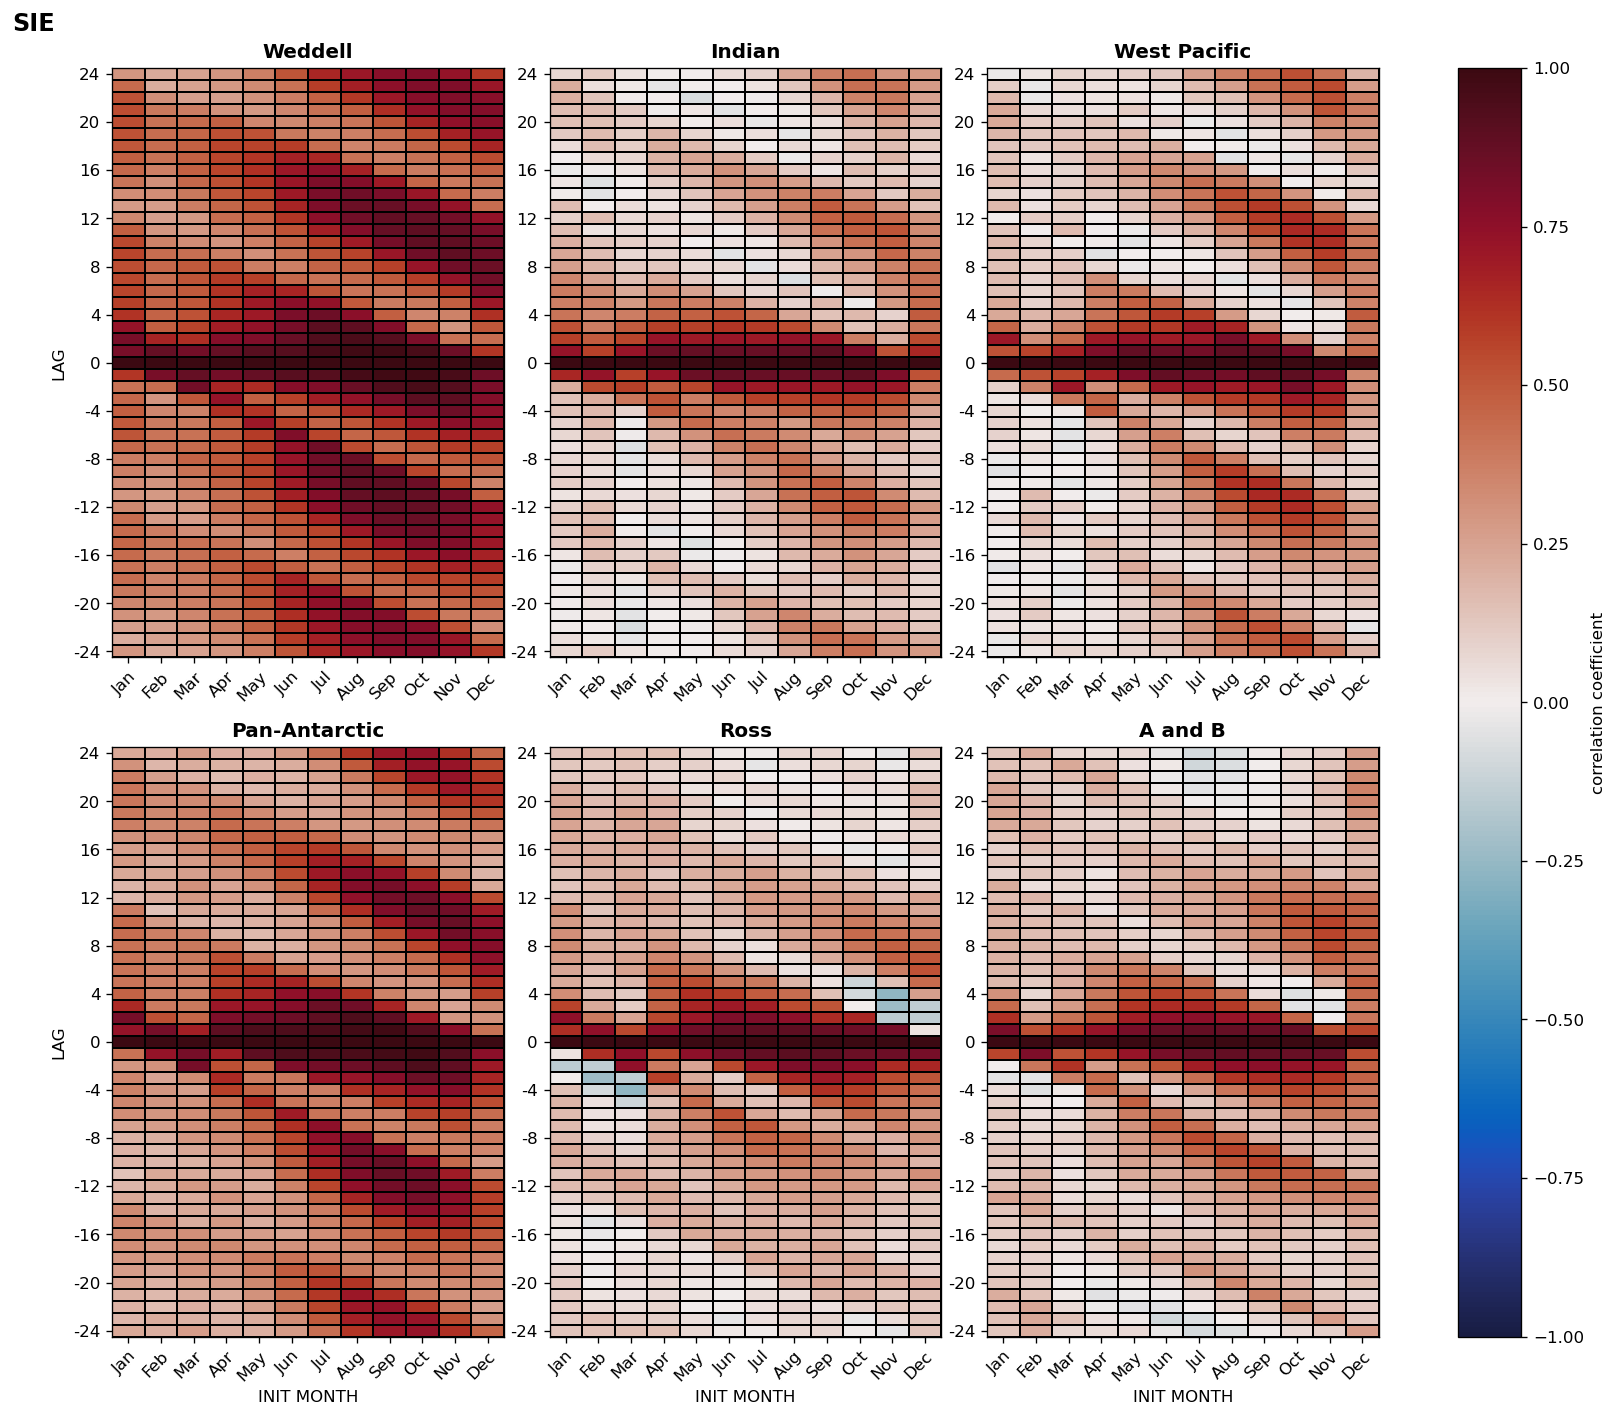

In [19]:
var = 'sie'
plot_regional_lagged_autocorr(var, hatch=False);

# Cross-correlation

## Test case

### Single init month

In [8]:
years = 10
N = 12 * years

## generate random time series of length N
## 0 is Jan, 1 is Feb, ..., 11 is Dec
a = np.arange(N)
b = np.arange(N)/100
print('predictand (a)', a, '\n')
print('predictor  (b)', b, '\n')

## initialization month
init = 11

## max absolute value lag (in months)
lag = -24

lag_values = np.arange(lag, 1)
for (im,m) in enumerate(lag_values):    
    trim = 12*((abs(m)-1)//12+1)
        
    if m == 0:
        tmp_predictand = a[init:N:12]
        tmp_predictor = b[init:N:12]
        
    else:
        tmp_predictand = a[init+trim:N:12]
        tmp_predictor = b[init+trim+m:N-trim+init:12]
     
#     if tmp_a_init.size != tmp_a_lag.size:
#         print('### lag', m)
#         print('### trim', trim)
#         print('### tmp_predictand (a)', tmp_predictand.size)
#         print('### tmp_predictor  (b)', tmp_predictor.size)
#         print('tmp_predictand (a)', tmp_predictand)
#         print('tmp_predictor  (b)', tmp_predictor, '\n')
        
#     else:
    print('lag', m)
    print('trim', trim)
    print('tmp_predictand (a)', tmp_predictand)
    print('tmp_predictor  (b)', tmp_predictor, '\n')

predictand (a) [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119] 

predictor  (b) [0.   0.01 0.02 0.03 0.04 0.05 0.06 0.07 0.08 0.09 0.1  0.11 0.12 0.13
 0.14 0.15 0.16 0.17 0.18 0.19 0.2  0.21 0.22 0.23 0.24 0.25 0.26 0.27
 0.28 0.29 0.3  0.31 0.32 0.33 0.34 0.35 0.36 0.37 0.38 0.39 0.4  0.41
 0.42 0.43 0.44 0.45 0.46 0.47 0.48 0.49 0.5  0.51 0.52 0.53 0.54 0.55
 0.56 0.57 0.58 0.59 0.6  0.61 0.62 0.63 0.64 0.65 0.66 0.67 0.68 0.69
 0.7  0.71 0.72 0.73 0.74 0.75 0.76 0.77 0.78 0.79 0.8  0.81 0.82 0.83
 0.84 0.85 0.86 0.87 0.88 0.89 0.9  0.91 0.92 0.93 0.9

### All (12) init months

In [9]:
maxlag = 2

## generate random time series of length N
years = 10
N = 12 * years
predictor = np.random.randint(0,100, (N))
predictand = np.random.randint(0,100, (N))

## rows are different lags, cols are different init months
r_matrix = np.zeros((maxlag+1, 12))
p_matrix = np.zeros((maxlag+1, 12))

lag_matrix = np.zeros((maxlag+1, 12))
init_matrix = np.zeros((maxlag+1, 12))

for (it,init) in enumerate(range(0,12)):
    for (ig,lag) in enumerate(range(maxlag+1)):    
        trim = 12*((abs(lag)-1)//12+1)
        init_matrix[ig][it] = init
        lag_matrix[ig][it] = lag

        tmp_predictand = predictand[init+trim:N:12]
        tmp_predictor = predictor[init+trim-lag:N-trim+init:12]
        
        r_matrix[ig][it], p_matrix[ig][it] = stats.pearsonr(tmp_predictand, tmp_predictor)

## Create function

In [4]:
## predictor --> the field doing the predicting (e.g., SIE or SFC_IRR)
## predictand --> the field being predicted (e.g., NPP)
def compute_lagged_xcorr(predictor, predictand, maxlag):
    ## convert DataArray to NumPy array
    predictor = predictor.values
    predictand = predictand.values
    
    assert predictor.size == predictand.size, 'predictor and predictand have different lengths'
    N = predictor.size
    
    ## rows are different init months, cols are different lags
    r_matrix = np.zeros((abs(maxlag)+1, 12))
    p_matrix = np.zeros((abs(maxlag)+1, 12))

    init_matrix = np.zeros((abs(maxlag)+1, 12))
    lag_matrix = np.zeros((abs(maxlag)+1, 12))
    
    lag_values = np.arange(maxlag, 1)
    for (it,init) in enumerate(range(0,12)):
        for (ig,lag) in enumerate(lag_values):   
            trim = 12*((abs(lag)-1)//12+1)
            init_matrix[ig][it] = init
            lag_matrix[ig][it] = lag
            
            if lag == 0:
                tmp_predictand = predictand[init:N:12]
                tmp_predictor = predictor[init:N:12]
                
            else:
                tmp_predictand = predictand[init+trim:N:12]
                tmp_predictor = predictor[init+trim+lag:N-trim+init:12]
            
            r_matrix[ig][it], p_matrix[ig][it] = stats.pearsonr(tmp_predictand, tmp_predictor)
            
    return r_matrix, p_matrix, init_matrix, lag_matrix

## Create figures

In [25]:
## compute t-test with 95 degrees of freedom (95% confidence interval) to determine threshold for hatching
def plot_single_lagged_xcorr(predictor, predictand, region, maxlag=-24, threshold=0.75, hatch='//', figsize=(6,7)):
    
    ts_predictor = open_metric(predictor, 'so', 'anom')[region]
    ts_predictand = open_metric(predictand, 'so', 'anom')[region]
    
    r, p, inits, lags = compute_lagged_xcorr(ts_predictor, ts_predictand, maxlag=maxlag)
    
    ## transform r so that lead=0 is the bottom row and lead=maxlag is top row
    numlags = r.shape[0]
    r_transformed = np.empty(shape=r.shape)
    for i in range(numlags):
        r_transformed[numlags-i-1] = r[i]
    r = r_transformed

    reg_names, var_su_names, abbrv_month_names = get_plotting_labels()

    fig,ax = plt.subplots(figsize=figsize)
    im = ax.pcolormesh(r, vmin=-1.0, vmax=1.0, cmap=cm.balance, edgecolor='k', linewidth=0.01)

    # for (i, j), z in np.ndenumerate(inits):
    #     ax.text(j+0.5, i+0.5, '%3d'%z, ha='center', va='center', fontsize=4)

    ax.set_yticks((np.arange(r.shape[0]) + 0.5))
    ax.set_yticklabels(np.arange(abs(maxlag)+1))
    ax.set_ylabel('LEAD')

    ax.set_xticks(np.arange(r.shape[1]) + 0.5)
    ax.set_xticklabels(abbrv_month_names)
    ax.set_xlabel('INIT MONTH')
    
    ax.set_title(reg_names[region]+' - '+var_su_names[predictor]+' predicting '+var_su_names[predictand])
   
    cb = fig.colorbar(im, ax=ax, label='correlation coefficient')

    if hatch:
        masked = np.ma.masked_array(r, mask=np.where(abs(r) > threshold, 0, 1))
        masked_im = ax.pcolor(masked, hatch=hatch, alpha=0)

        cb.ax.plot([-1,1], [threshold,threshold], color='k')
        cb.ax.plot([-1,1], [-threshold,-threshold], color='k')
        cb.ax.fill_between([-1,1], [1,1], [threshold,threshold], hatch=hatch, alpha=0)
        cb.ax.fill_between([-1,1], [-threshold,-threshold], [-1,-1], hatch=hatch, alpha=0)

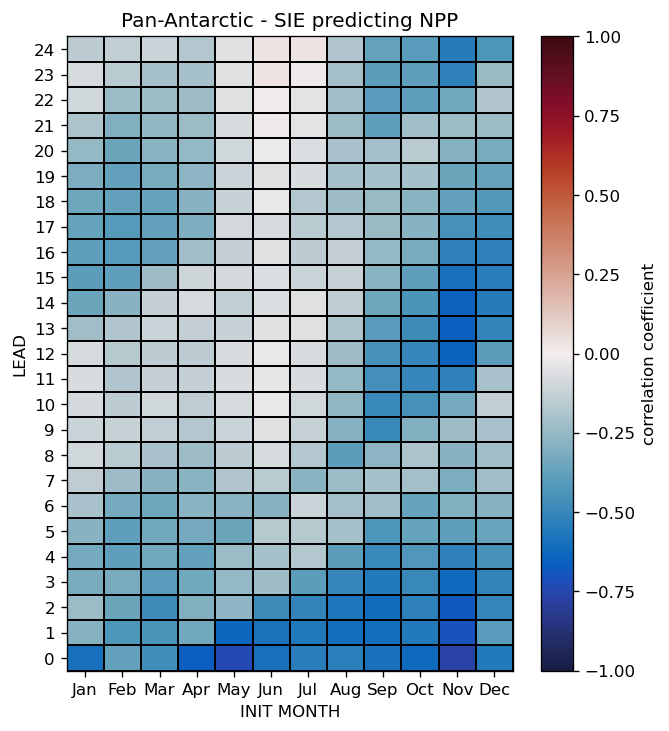

In [26]:
predictor = 'sie'
predictand = 'npp'
plot_single_lagged_xcorr(predictor, predictand, 'SouthernOcean', maxlag=-24, hatch=False)

In [29]:
def plot_regional_lagged_xcorr(predictor, predictand, maxlag=-24, threshold=0.75, hatch='//', figsize=(14,12)):
    reg_names, var_su_names, abbrv_month_names = get_plotting_labels()
    region_list = ['Weddell', 'Indian', 'WestPacific', 'SouthernOcean', 'Ross', 'AmundBell']

    fig,ax = plt.subplots(2, 3, figsize=figsize)
    
    for (ireg,reg) in enumerate(region_list):  
        ts_predictor = open_metric(predictor, 'so', 'anom')[reg]
        ts_predictand = open_metric(predictand, 'so', 'anom')[reg]

        r, p, inits, lags = compute_lagged_xcorr(ts_predictor, ts_predictand, maxlag=maxlag)
    
        ## transform r so that lead=0 is the bottom row and lead=maxlag is top row
        numlags = r.shape[0]
        r_transformed = np.empty(shape=r.shape)
        for i in range(numlags):
            r_transformed[numlags-i-1] = r[i]
        r = r_transformed
        
        im = ax[int(ireg/3),ireg%3].pcolormesh(r, vmin=-1.0, vmax=1.0, cmap=cm.balance, edgecolor='k', linewidth=0.01)
        
        if hatch:
            masked = np.ma.masked_array(r, mask=np.where(abs(r) > threshold, 0, 1))
            masked_im = ax[int(ireg/3),ireg%3].pcolor(masked, hatch=hatch, alpha=0)
        
        ax[int(ireg/3),ireg%3].set_yticks((np.arange(r.shape[0]) + 0.5)[::4])
        ax[int(ireg/3),ireg%3].set_yticklabels(np.arange(0,25)[::4])
        ax[int(ireg/3),ireg%3].set_xticks(np.arange(r.shape[1]) + 0.5)
        ax[int(ireg/3),ireg%3].set_xticklabels(abbrv_month_names, rotation=45, ha="right", rotation_mode="anchor")
        ax[int(ireg/3),ireg%3].set_title(reg_names[reg], fontweight='bold', fontsize='large')
        
        if ireg%3 == 0:
            ax[int(ireg/3),ireg%3].set_ylabel('LEAD')
        if ireg//3 == 1:
            ax[int(ireg/3),ireg%3].set_xlabel('INIT MONTH')
    
    fig.suptitle(var_su_names[predictor]+' predicting '+var_su_names[predictand], x=0, fontweight='bold', fontsize='x-large')
    fig.tight_layout()
    
    cb = fig.colorbar(im, ax=ax.ravel().tolist(), label='correlation coefficient')
    
    if hatch:
        cb.ax.plot([-1,1], [threshold,threshold], color='k')
        cb.ax.plot([-1,1], [-threshold,-threshold], color='k')
        cb.ax.fill_between([-1,1], [1,1], [threshold,threshold], hatch=hatch, alpha=0)
        cb.ax.fill_between([-1,1], [-threshold,-threshold], [-1,-1], hatch=hatch, alpha=0)
        
    return fig,ax

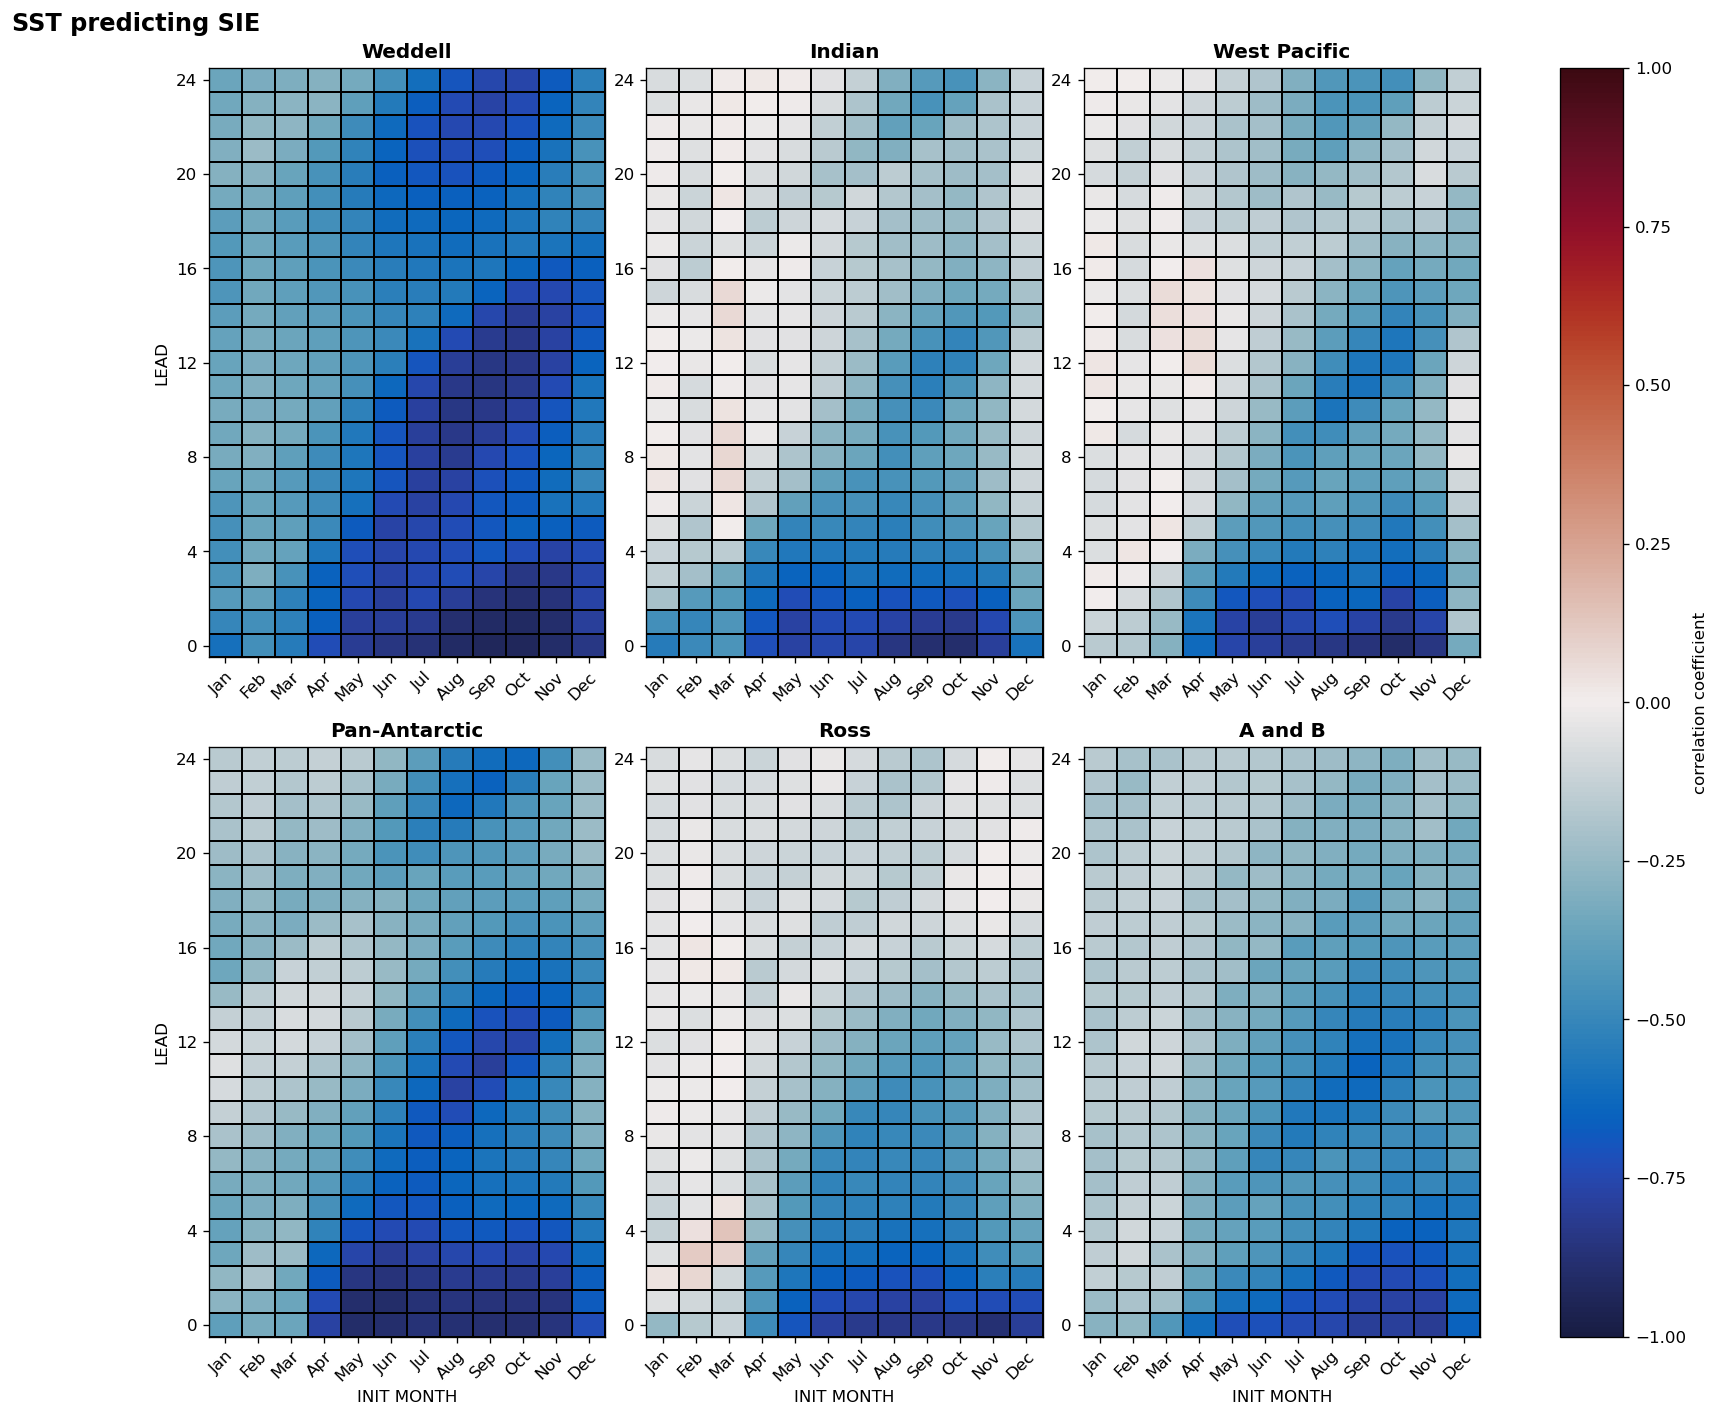

In [41]:
predictor = 'sst'
predictand = 'sie'
plot_regional_lagged_xcorr(predictor, predictand, hatch=False);